# Research Question

**Can Pointnet neural networks be used to identify timeslices with neutrino events?**

Yes, it can be used, after several modifications (see PointNet Architecture below)

**Can it perform with sufficient accuracy, and recall?**

As of now, it does not meet the industry requirements. However, since there is no such previous work, 
the results of this thesis will set a benchmark for how well pointnet can perform

**Can energy properties be inferred from the network?**

No. Pointnet cannot be used for regression, as it is a classification network

# The Pipeline

**Data pre-processing** ---> **Data Sampling** ----> **Pointcloud Generation** ----> **3D Mesh Generation** ----> **Training** ----> **Evaluation**
        
# Data Pre-processing 

1. Addition of timeslice groups [Relevant Notebooks](./data_generation/)

The dataset is divided into timeslice groups based on time chunks of 150000 nanoseconds. Each timeslice group contains xyz and time values, aside from other metadata. This will allow the network will identify if the timeslice contains neutrino hits or not. 

2. Removal of irrelevant columns [Relevant Notebook](./data_preparation/0.0_dataset_reduction.ipynb)

# Data Sampling 
#### [Relevant Notebook](./ensemble/sampled/1.0_xyt_data_preparation_separate_sampling.ipynb)

1. Generate classes:
Separate timeslice groups into two classes:
    1. `Class 0` groups that have only noise points
    2. `Class 1` groups that have both noise and hits (referenced as mixed groups)

2. For each class, separate into train and test groups
Groups are further split into train and test groups

3. Groups identified as test groups are directly saved
This is because test data must not be tocuhed and manipulated in any way

4. Groups identified as training groups are further sampled
There is severe class imbalance within groups in `Class 1` that contains both hits and noise points. This can severely impact training performance. For this, the data is further sampled.


# PointCloud Generation
#### [Relevant Notebook](./ensemble/sampled/1.0_xyt_data_preparation_separate_sampling.ipynb)

1. Save the relevant pointclouds
Each timeslice group is saved as individual `group_#.xyz` file

# 3D Mesh Generation
#### [Relevant Notebook](./ensemble/sampled/mesh_generation.ipynb)

1. Compute normals for each timeslice group: 
Normals are oriented  with respect to the input point cloud if normals exist. Next, converts float64 numpy array of shape (n, 3) to Open3D format. Normals are required to generate meshes.

2. Generate Poission Mesh: (See Screened Poission Reconstruction for more information below)
Implements the Screened Poisson Reconstruction proposed in Kazhdan and Hoppe, "Screened Poisson Surface Reconstruction", 2013. See https://github.com/mkazhdan/PoissonRecon

3. Save as `.off` files
The network specifically handles `.off` files
    
#### Screened Poisson Reconstruction
It uses an approach known as an implicit meshing method, which is trying to “envelop” the data in a smooth cloth. We try to fit a watertight surface from the original point set by creating an entirely new point set representing an isosurface linked to the normals. There are several parameters available that affect the result of the meshing:

1. Depth:
Tree-depth is used for the reconstruction. The higher, the more detailed the mesh. With noisy data you keep vertices in the generated mesh that are outliers but the algorithm doesn’t detect them as such. So a low value (maybe between 5 and 7) provides a smoothing effect, but you will lose detail. The higher the depth-value the higher is the resulting amount of vertices of the generated mesh.

2. Width: 
This specifies the target width of the finest level of the tree structure, which is called an octree. D

3. Scale:
It describes the ratio between the diameter of the cube used for reconstruction and the diameter of the samples’ bounding cube. Very abstract, the default parameter usually works well.

4. Fit:
The linear_fit parameter if set to true, let the reconstructor use linear interpolation to estimate the positions of iso-vertices.



# Organisation of files 
PointNet NN requires data to be made available in the following scheme:
- `class1`  
    - `train`
        * file.off
        * file.off 
    - `test` 
        * file.off
        * file.off
- `class2`
    - train 
        * file.off
        * file.off    
    - `test`  
        * file.off
        * file.off
        
# PointNet Architecture 

Requirements for point cloud data:

1. Point clouds should be unordered. Algorithm has to be invariant to permutations of the input set.
2. Network must be invariant to rigid transformations.
3. Network should capture interactions among points.

Following are the modifications made to PointNet to work with KM3Net Data:

1. Mapping `.off files`

The dataset consists of .off files that contain meshes represented by vertices and triangular faces. Vertices are points in a 3D space and each triangle is formed by 3 vertex indices.


2. Point sampling (As per https://github.com/fxia22/pointnet.pytorch)

As points are not uniformly distributed across object’s surface, it will be difficult for  PointNet to classify them. 
Points are therefore uniformly sampled on the object’s surface. Faces can have different areas and hence we may assign probability of choosing a particular face proportionally to its area. 
As the network will have dense layers in the architecture, a fixed number of points are required per point cloud. For this, faces are sampled from the constructed distribution. After that, one point per chosen face gets sampled.

3. Augmentations
That pointclouds can have different sizes and can be placed in different parts of the coordinate system.
So, they are translated to the origin by subtracting mean from all its points and normalizing its points into a unit sphere. To augment the data during training, we randomly rotate objects around Z-axis and add Gaussian noise as described in the original paper.

4. Model
The key point is that the result should be invariant to input points permutations and geometric transformations, such as rigid transformations.
    1. First tensors will have size (batch_size, num_of_points, 3). In this case MLP with shared weights is just 1-dim convolution with a kernel of size 1.
    2. To ensure invariance to transformations, apply the 3x3 transformation matrix predicted by T-Net to coordinates of input points. It is not possible to encode translations in 3D space by a 3-dimensional matrix. This is therefore taken care of by translating point clouds to the origin during pre-processing.
    3. For initialisation of the output matrix, it should be an identity matrix by default to start training with no transformations at all. So, an identity matrix is added to the output. Additionally, the same but 64-dim T-Net is used to align extracted point features after applying MLP.
    4. To provide permutation invariance, a symmetric function (max pooling) is applyed to the extracted and transformed features so the result does not depend on the order of input points anymore.
    5. Loss is chosen to be NLLoss() with Log Sigmoid activation function (based on experiments mentioned below)

# Future Ideas

1. LSTM Units
2. Adding 4D points to Pointnet (time as a feature)

# Problem At Hand
(Identified on 22-August-2020)

When sampling 6550 points only per timeslice for both train and test ie. using a small subset of data per timeslice, there is distinct difference between the two types of classes, allowing for the classifier to classify with great accuraccy.

![](assets/experiments/problem/noise_6550.png)
![](assets/experiments/problem/mixed_6550.png)

However, without this sampling, the meshes look very similar to each other. 
![](assets/experiments/problem/noise_unsampled.png)
![](assets/experiments/problem/mixed_unsampled.png)

# Currently Working on Exploring Mesh Algorithms

### Problem:
Based on images above, it is clear that timeslices as a whole do not show enough distinction between mixed and noise. This is solely due to the Poission Mesh Algorithm. 


### Requirements:
Find a mesh a;gorithm that can suitably identify these distinct features


### Options:
1 BPA


# Experiments:

Due to the exploratory nature of the research question, i.e. can PointNets work with such a problem, several experiments were carries out in phases.

1. Meshes`xyz` -> Experiment stopped based on feedback from progress meeting

2. Points`xyz` -> Experiment stopped for the same reason as above
The Network can also work with just points and not 3D meshes. But it is unable to learn much information

3. Ensemble of Meshes `xyt`, `xzt` `yzt` --> Finalised Setup
Here `time` is made part of the dataset as per Physics requirements

**Best Accuraccy Overall: 66%**

**Recall (Class1/Class0): 40%/90%**

**Loss: 0.001**

# Meshes `xyz`

#### Exp 1.0:
**Date:** 09-Jul-2020

**Parameters:**
1024 points
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. logsoftmax

**Train Results (Best Score):**
accuraccy: 50 % 

**Test Results:**
![](assets/experiments/exp_1.0.png)

#### Exp 2.0:
**Date:** 10-Jul-2020

**Parameters:**
1024 points
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. **Changed: LogSigmoid** 

**Train Results:**
accuraccy: 59 %

**Test Results:**
![](assets/experiments/exp_2.0.png)

##### Exp 2.1:
**Date:** 10-Jul-2020

**Parameters:**
1024 points
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. **Changed: Sigmoid** 

**Rationale**
Does changing between log sigmoid vs sigmoid have any effect on results?
It actually decreased training performance

**Train Results:**
accuraccy: 50 %

**Test Results:**
![](assets/experiments/exp_2.1.png)

#### Exp 3.0: 
**Date:** 11-Jul-2020
**Results:**
1024 Max points
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. LogSigmoid
5. **Changed:LossFunction - BinaryEntropyLoss**

**Rationale**
The loss function for predicting binary outcomes should be Binary Loss Entropy

**Result**
No real difference between negative log likelihood loss mathematically

##### Exp 3.1:
**Date:** 11-Jul-2020

**Parameters:**
1024 Max points
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. LogSigmoid
5. **Changed:LossFunction - CrossEntropyLoss**

**Rationale**
Binary Loss Entropy did not work. Tried Crossentropy (multiclass as binary problem)

**Train Results:**
accuraccy: 54 %

**Test Results:**
![](assets/experiments/exp_3.1.png)

#### Exp 4.0:
**Date:** 13-Jul-2020

**Parameters: Evaluating a Larger Model**

**Changed: Max points to 2048**
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. LogSigmoid
5. NNLoss

**Train Results:**
accuraccy: 50 %

**Remarks**
No real difference


#### Exp 5.0:
**Date:** 13-Jul-2020

**Parameters:**
**Changed: Increased files to 200 per type**
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. LogSigmoid
5. NNLoss

**Train Results:**
accuraccy: 60 %
loss: 0.009


**Remarks**
Produced 60% validation scores. Loss decrease rate stabalises around 10-11 epochs

**Test Results:**
![](assets/experiments/exp_5.0.png)


##### Exp 5.1:
**Date:** 13-Jul-2020

**Parameters:**
200 Files/Class
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. **Changed: Sigmoid **
5. NNLoss

**Train Results:**
accuraccy: 60 %


**Rationale**
Sigmoid produced a more precise confusion matrix despite lower scores


**Remarks**
Produced 60% validation scores. Loss decrease rate stabalises around 10-11 epochs

**Test Results:**
![](assets/experiments/exp_5.0.png)

# Ensemble Meshes `XYT XZT YZT`

#### Exp 1.0: 
**Date:** 05-August-2020

**Condition:** 6550 points per timeslice were taken. Hits ordered first so
that they would be selected first and the balance would be noise points

**Parameters:**
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. LogSigmoid
5. NNLoss

**Train Results:**
[Epoch: 14, Batch:   10 /   10], loss: 0.006
Valid accuracy: 97 %

**Classification report**

               precision    recall  f1-score   support

       mixed       1.00      0.93      0.96        40
       noise       0.93      1.00      0.96        40

    accuracy                           0.96        80
    macro avg       0.97      0.96     0.96        80
    weighted avg    0.97      0.96     0.96        80


**Remarks**
Very high accuraccy, precision and recall. However, this is on a very small subset of data. 

<!-- <img src="../assets/experiments/ensemble/exp_1.0.png"> -->
![alt text](assets/experiments/ensemble/exp_1.0.png)

#### Exp 1.1: 
**Date:** 05-August-2020

**Condition**

Test data must be a large set, to mimic real world scenario

1. Split to train/test
2. Train is resampled down to 6550 pints only
3. Test is left untouched


**Parameters:**
1. Sampled, normalised, 6550 points
2. Rotated
3. Added Noise
4. LogSigmoid
5. NNLoss

**Train Results:**
[Epoch: 14, Batch:   10 /   10], loss: 0.009
Valid accuracy: 50 %

**Classification report**

Classification report for Pointnet:

             precision  recall   f1-score   support
               
       0      0.45       0.75      0.57       40
       1      0.29       0.10      0.15       40
       
    accuracy                      0.42        80

![](assets/experiments/ensemble/exp_1.1.png)

#### Exp 1.2: 
**Date:** 08-August-2020

**Condition**
6550 train, all test


1. Split to train/test
2. Train is resampled down to 6550 pints only
3. Test is left untouched

**Parameters:**
1. Sampled, normalised, 1024 points 
2. Rotated
3. Added Noise
4. LogSigmoid
5. NNLoss

**Train Results:**
[Epoch: 10, Batch:   10 /   10], loss: 0.010
Valid accuracy: 61 %


**Classification report**


Classification report for Pointnet:

               precision    recall  f1-score   support

       mixed       0.60      0.23      0.33        40
       noise       0.52      0.85      0.65        40

    accuracy                           0.54        80
   macro avg       0.56      0.54      0.49        80
weighted avg       0.56      0.54      0.49        80

![](assets/experiments/ensemble/exp_1.1.png)

#### Exp 1.3: 
**Date:** 08-August-2020

**Condition**
6550 train, all test


1. Split to train/test
2. Train is resampled down to 6550 pints only
3. Test is left untouched

**Parameters:**
1. Sampled, normalised, 1024 points 
2. Rotated
3. Added Noise
4. **Sigmoid**
5. **BCELoss**
5. **30 epochs**

**Train Results:**
Valid accuracy: 55 %
[Epoch: 23, Batch:   10 /   10], loss: 0.114

Also, loss was fluctuating and never settled into minima

**Classification report**


Classification report for Pointnet:

               precision    recall  f1-score   support

       mixed       0.52      0.60      0.56        40
       noise       0.53      0.45      0.49        40

    accuracy                           0.53        80
    macro avg       0.53      0.53     0.52        80
    weighted avg    0.53      0.53     0.52        80

![](assets/experiments/ensemble/exp_1.3.png)

#### Exp 1.4: 
**Date:** 08-August-2020

**Condition**
6550 train, all test


1. Split to train/test
2. Train is resampled down to 6550 pints only
3. Test is left untouched

**Parameters:**
1. Sampled, normalised, 1024 points 
2. Rotated
3. Added Noise
4. **BCEWithLogitsLoss**
5. **60 epochs**

**Train Results:**
[Epoch: 12, Batch:   10 /   10], loss: 0.130
Valid accuracy: 65 %

Also, loss was fluctuating and never settled into minima

**Classification report**

Classification report for Pointnet:

               precision    recall  f1-score   support

       mixed       0.52      0.35      0.42        40
       noise       0.51      0.68      0.58        40

    accuracy                           0.51        80
    macro avg       0.51      0.51     0.50        80
    weighted avg    0.51      0.51     0.50        80

![](assets/experiments/ensemble/exp_1.4.png)

#### Exp 1.5: 
**Date:** 08-August-2020

**Condition**
6550 train, all test


1. Split to train/test
2. Train is resampled down to 6550 pints only
3. Test is left untouched

**Parameters:**
1. Sampled, normalised, 1024 points 
2. Rotated
3. Added Noise
4. **Cross Entropy Loss (includes sigmoid)**
5. **80 epochs**

**Train Results:**
[Epoch: 59, Batch:   10 /   10], loss: 0.708
Valid accuracy: 65 %

Also, loss was fluctuating and never settled into minima (0.710-0.687)

**Classification report**

Classification report for Pointnet:

               precision    recall  f1-score   support

        mixed       0.80      0.40      0.53        40
        noise       0.60      0.90      0.72        40

     accuracy                           0.65        80
    macro avg       0.70      0.65      0.63        80
    weighted avg    0.70      0.65      0.63        80

![](assets/experiments/ensemble/exp_1.5.png)

#### Exp 2.0: 
**Date:** 05-August-2020

**Condition:** No points sampled

**Parameters:**
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. LogSigmoid
5. NNLoss

**Train Results:**
[Epoch: 14, Batch:   10 /   10], loss: 0.009
Valid accuracy: 57 %

**Classification report**

               Classification report for Pointnet:

               precision    recall  f1-score   support

       mixed       0.38      0.15      0.21        40
       noise       0.47      0.75      0.58        40

    accuracy                           0.45        80
    macro avg       0.42      0.45     0.40        80
    weighted avg    0.42      0.45     0.40        80




![](assets/experiments/ensemble/exp_2.0.png)

#### Exp 3.0: 
**Date:** 08-August-2020

**Condition:** Classes set to **k = 1** (instead of k = 2)

**Parameters:**
1. Sampled, normalised,
2. Rotated
3. Added Noise
4. Sigmoid
5. BCE
6. 80 epochs

**Train Results:**
No improvements

**Classification report**
No improvements      

#### Exp 4.0: Ensemble Best Loss Functiom

Choosing the best loss function: BCEWith Logits, NLLLoss, CrossEntropyLoss

**Date:** 15-August-2020

No 6550 points, full data

**Condition:** 
Batch:[32, 64]
Epoch: 250    
    
**Parameters:**
1. Sampled, normalised,
2. Rotated
3. Added Noise


                   BCEWLogitsLoss     NLLoss      CELoss
       Recall
       
       mixed           0.62             0.53       0.35  
       noise           0.40             0.55       0.55


       FPR             0.65             0.475       0.60
       
   
BCEWithLogitsLoss gives highest acccuraccy but NLLoss gives lowest FPR overall.

**Result: Proceed with NLLoss.

# Ensemble Meshes with Preprocessing

Based on exploration of meshes and algorithms to manipulate meshes, it was decided that Radius based outlier removal would be undertaken. Based on this, `xyz` points were first thus preprocessed and then meshed.

#### Exp 1.0:

**Date:** 07-September-2020

6550 points per tensor

**Condition:** 
Epoch: 250    

eps= 100
radius multiplier = 3.0
    

 **Train Results:**
[Epoch: 39 Batch:   10 /   10], loss: 0.001
Valid accuracy: 100 %

**Classification report**

               Classification report for Pointnet:

               precision    recall  f1-score   support

       mixed       1          1        1         40
       noise       1          1        1         40

    accuracy                           1         80
    macro avg       1         1        1         80
    weighted avg    1         1        1         80




![](assets/experiments/ensemble/processed_mesh/1_cgc.png)
![](assets/experiments/ensemble/processed_mesh/1_prc.png)
![](assets/experiments/ensemble/processed_mesh/1_roc.png)

#### Exp 1.1:

**Date:** 07-September-2020

1024 points per tensor

**Condition:** 
Epoch: 50  

eps= 100
radius multiplier = 3.0
    

 **Train Results:**
[Epoch: 39 Batch:   10 /   10], loss: 0.001
Valid accuracy: 98 %

**Classification report**

               Classification report for Pointnet:

               precision    recall  f1-score   support

      mixed       1.00      0.95      0.97        40
      noise       0.95      1.00      0.98        40

    accuracy                            0.97        80
    macro avg       0.98      0.97      0.97        80
    weighted avg    0.98      0.97      0.97        80




![](assets/experiments/ensemble/processed_mesh/1.1_cgc.png)
![](assets/experiments/ensemble/processed_mesh/1.1_cm.png)
![](assets/experiments/ensemble/processed_mesh/1.1_roc.png)

#### Exp 2.0:

**Date:** 10-September-2020

6550 points per tensor

**Condition:** 
Epoch: 50  

eps= 100
radius multiplier = 4.6
    

 **Train Results:**
Classification report for Pointnet:

               precision    recall  f1-score   support

       mixed       1.00      0.35      0.52        40
       noise       0.61      1.00      0.75        40

    accuracy                           0.68        80
   macro avg       0.80      0.68      0.64        80
weighted avg       0.80      0.68      0.64        80


**Classification report**

               


# ![](assets/experiments/ensemble/processed_mesh/2.0_cgc.png)
# ![](assets/experiments/ensemble/processed_mesh/2.0_prc.png)
# ![](assets/experiments/ensemble/processed_mesh/2.0_roc.png)

#### Exp 2.1:

**Date:** 11-September-2020

***8000** points per tensor

**Condition:** 
Epoch: 50  

eps= 100
radius multiplier = 4.6
    

 **Train Results:**


**Classification report**
# ![](assets/experiments/ensemble/processed_mesh/2.0_cgc.png)
# ![](assets/experiments/ensemble/processed_mesh/2.0_prc.png)
# ![](assets/experiments/ensemble/processed_mesh/2.0_roc.png)

#### Exp 3.0:

**Date:** 11-September-2020

***8192** points per tensor

**Condition:** 
Epoch: 50  

eps= 100
radius multiplier = **3.6**
    
    

 **Train Results:**
[Epoch: 50, Batch:   10 /   10], loss: 0.034
Valid accuracy: 93 %

**Classification report**

               precision    recall  f1-score   support

       mixed       0.97      0.90      0.94        40
       noise       0.91      0.97      0.94        40

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



# ![](assets/experiments/ensemble/processed_mesh/3.0_cgc.png)
# ![](assets/experiments/ensemble/processed_mesh/3.0_roc.png)
# ![](assets/experiments/ensemble/processed_mesh/3.0_cm.png)
# ![](assets/experiments/ensemble/processed_mesh/3.0_cmn.png)


#### Exp 4.0: POINTS

**Date:** 11-September-2020

***8192** points per tensor

**Condition:** 
Epoch: 100 

eps= 100
radius multiplier = **3.6**
    
    

 **Train Results:**
[Epoch: 50, Batch:   10 /   10], loss: 0.034
Valid accuracy: 93 %

**Classification report**

               precision    recall  f1-score   support

       mixed       0.52      0.70      0.60        40
       noise       0.54      0.35      0.42        40

    accuracy                           0.53        80
   macro avg       0.53      0.52      0.51        80
weighted avg       0.53      0.53      0.51        80



# ![](assets/experiments/ensemble/processed_mesh/4.0_cgc.png)
# ![](assets/experiments/ensemble/processed_mesh/4.0_roc.png)
# ![](assets/experiments/ensemble/processed_mesh/4.0_cm.png)

# Final Ensemble: `xyt`, `xzt`, `yzt`

(Here both noise and hits timeslices are filtered)

##### `xyt`

Classification report for Pointnet:

                   precision    recall  f1-score   support

       mixed           1.00      0.90      0.95        40
       noise           0.91      1.00      0.95        40

       accuracy                            0.95        80
       macro avg       0.95      0.95      0.95        80
       weighted avg    0.95      0.95      0.95        80

##### `xzt`

Classification report for Pointnet:

                   precision   recall   f1-score   support

       mixed          1.00      0.85      0.92        40
       noise          0.87      1.00      0.93        40

       accuracy                           0.93        80
       macro avg      0.93      0.93      0.92        80
       weighted avg   0.93      0.93      0.92        80


##### `yzt`

Classification report for Pointnet:

                  precision    recall  f1-score   support

       mixed         0.98       1.00      0.99        40
       noise         1.00       0.97      0.99        40

       accuracy                           0.99        80
       macro avg      0.99      0.99      0.99        80
       weighted avg   0.99      0.99      0.99        80


##### Hard Voting
                    precision    recall  f1-score   support

       mixed           0.97       0.97      0.97        40
       noise           0.97       0.97      0.97        40

       accuracy                             0.97        80
       macro avg       0.97       0.97      0.97        80
       weighted avg    0.97       0.97      0.97        80
    
    
##### Soft Voting 

    Soft Voting Voting: Classification report for Pointnet:

                   precision    recall   f1-score    support

       mixed           0.98      1.00      0.99        40
       noise           1.00      0.97      0.99        40

       accuracy                            0.99        80
       macro avg       0.99      0.99      0.99        80
       weighted avg    0.99      0.99      0.99        80


The output neuron looked something like this: [32, 2] matrix indicating that one neuron was assigned for. each class (k = 2). This makes it NOT a binary classification problem but a **Predicting a single label from multiple classes** problem.

## Predicting a single label from multiple classes ##
The final layer of the neural network will have one neuron for each of the classes and they will return a value between 0 and 1, which can be inferred as a probably. The output then results in a probability distribution as it sums to 1.
To understand the accuracy of the prediction, each output is compared with its corresponding true value. True values have been one-hot-encoded meaning a 1 appears in the column corresponding to the correct category, else a 0 appears


Softmax with cross entropy should be tried


## Binary Classification Loss Functions [UPDATE: INVALID]

[o] ***Binary Cross-Entropy:***
Cross-entropy is the default loss function to use for binary classification problems. 
It is intended for use with binary classification where the target values are in the set {0, 1}. Mathematically, it is the preferred loss function under the inference framework of maximum 
likelihood. 
It is the loss function to be evaluated first and only changed if you have a good reason.
Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for predicting class 1. 
The score is minimized and a perfect cross-entropy value is 0.


[x] ***Hinge Loss:*** 
An alternative to cross-entropy for binary classification problems is the hinge loss function, primarily developed for use with Support Vector Machine (SVM) models.It is intended for use with binary classification where the target values are in the set {-1, 1}.

[x] ***Squared Hinge Loss:*** 
Calculates the square of the score hinge loss. It has the effect of smoothing the surface of the error function and making it numerically easier to work with. If using a hinge loss does result in better performance on a given binary classification problem, is likely that a squared hinge loss may be appropriate. As with using the hinge loss function, the target variable must be modified to have values in the set {-1, 1}.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

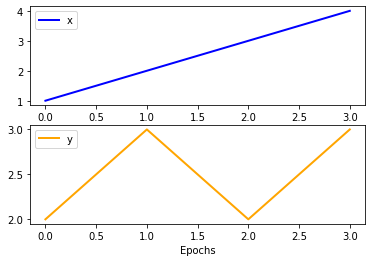

In [35]:
x = [1, 2, 3, 4]
y= [2, 3, 2, 3]
# a = plt.plot(x, linewidth=2.0, label='x')
# plt.xlabel('Epochs')
# plt.legend()
           
# b= plt.plot(y, linewidth=2.0, label='y')
# plt.xlabel('Epochs')
# plt.legend()



plt.figure(1)
plt.subplot(211)
plt.plot(x, linewidth=2.0, color='blue', label='x')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(212)
plt.plot(y, linewidth=2.0, color='orange', label='y')
plt.xlabel('Epochs')
plt.legend()


Noted that the read method converts to floats that looses several points

Adding a 4th dimension: https://github.com/charlesq34/pointnet/issues/213
https://github.com/charlesq34/pointnet/issues/12
https://github.com/fxia22/pointnet.pytorch/issues/69


Helpful visualisations: [https://github.com/Wind-Wing/pointnet-visualization/blob/master/visualization_report.pdf]